<a href="https://www.kaggle.com/code/arnavr10880/tensorflow-spaceship-titanic-with-keras?scriptVersionId=93602212" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align='center'> Spaceship Titanic with Tensorflow </h1>

<center><img src='https://pyimagesearch.com/wp-content/uploads/2019/10/keras_vs_tfdotkeras_header.png'></img></center>

<p style='font-size: 17px'>Thank you for reading this notebook!</p>

<p style='font-size: 17px'>This notebook aims to solve the <strong>Spaceship Titanic</strong> mystery with the help of <strong>Neural Networks</strong> using <strong>Tensorflow-keras.</strong></p>
    
<p style='font-size: 17px'>For detailed EDA with LightGBM, check out this notebook: <a style='font-weight: 900'>https://www.kaggle.com/code/arnavr10880/spaceshiptitanic-eda-fe-optimization</a></p>

<hr>

# Notebook contents

- <a href='#libraries'> Required Libraries </a>
- <a href='#dataset'> Reading the dataset </a>
- <a href='#pre'> Pre-processing the data </a>
- <a href='#engg'> Feature Engineering </a>
- <a href='#prepare'> Preparing for training </a>
- <a href='#nn'> Neural Network Architecture (Model) </a>
- <a href='#tuning'> Model Training (with hyperparameter tuning) </a>
- <a href='#viz'> Visualizing evaluation </a>
    - <a href='#accuracy'> Plotting Accuracy & Loss Plots </a>
    - <a href='#confusion'> Confusion Matrix </a>
- <a href='#final'> Performing final predictions </a>

<br/><br/>
<hr>

<a id='libraries'></a>
# Required Libraries

In [1]:
# !pip install keras-tuner --upgrade

In [2]:
# Keras & Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import keras_tuner as kt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# sklearn libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, Normalizer

<a id='dataset'></a>
# Reading the dataset

In [3]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

<a id='pre'></a>
# Pre-processing the data

<p style='font-size: 17px'>Here, we'll do some pre-processing which involves filling the missing values.</p>

In [4]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer()
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

In [5]:
train['HomePlanet'].fillna('Earth', inplace=True)
train['CryoSleep'].fillna('False', inplace=True)
train['Cabin'].fillna('None', inplace=True)
train['Destination'].fillna('TRAPPIST-1e', inplace=True)
train['VIP'].fillna('False', inplace=True)

test['HomePlanet'].fillna('Earth', inplace=True)
test['CryoSleep'].fillna('False', inplace=True)
test['Cabin'].fillna('G/109/P', inplace=True)
test['Destination'].fillna('TRAPPIST-1e', inplace=True)
test['VIP'].fillna('False', inplace=True)

train['Name'].fillna('no name', inplace=True)
test['Name'].fillna('no name', inplace=True)

<a id='engg'></a>
# Feature Engineering

<p style='font-size: 17px'>We'll be doing some feature engineering by creating new features out of the others.</p>

In [6]:
train['Deck'] = train['Cabin'].apply(lambda x:str(x)[:1])
train['Side'] = train['Cabin'].apply(lambda x:str(x)[-1:])
test['Deck'] = train['Cabin'].apply(lambda x:str(x)[:1])
test['Side'] = train['Cabin'].apply(lambda x:str(x)[-1:])

train['PGroup'] = train['PassengerId'].apply(lambda x: x.split('_')[0])
train['PNumber'] = train['PassengerId'].apply(lambda x: x.split('_')[1])
test['PGroup'] = test['PassengerId'].apply(lambda x: x.split('_')[0])
test['PNumber'] = test['PassengerId'].apply(lambda x: x.split('_')[1])

train['LastName'] = train['Name'].apply(lambda x:x.split(" ")[1])
test['LastName'] = train['Name'].apply(lambda x:x.split(" ")[1])

train['AllServices'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['AllServices'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

<p style='font-size: 17px'>As machine learning models only love numbers, we'll encode the categorical columns using <strong>Label Encoder</strong>.</p>

In [7]:
label_cols = ["HomePlanet", "CryoSleep", "Destination" ,"VIP", "Deck", "Side", "LastName", "PGroup", "PNumber"]

for i in label_cols:
    train[i] = train[i].astype(str)
    test[i] = test[i].astype(str)
    train[i] = LabelEncoder().fit_transform(train[i])
    test[i] = LabelEncoder().fit_transform(test[i])

In [8]:
train['Transported'] = LabelEncoder().fit_transform(train['Transported'])
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PGroup,PNumber,LastName,AllServices
0,0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,0,0,0,1431,0.0
1,0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,5,1,1,0,2109,736.0
2,0003_01,1,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,2,0,1990,10383.0
3,0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,2,1,1990,5176.0
4,0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,5,1,3,0,1778,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,0,A/98/P,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,0,6213,0,1416,8536.0
8689,9278_01,0,1,G/1499/S,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,6,1,6214,0,1341,0.0
8690,9279_01,0,0,G/1500/S,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,6,1,6215,0,470,1873.0
8691,9280_01,1,0,E/608/S,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,4,1,6216,0,996,4637.0


<a id='prepare'></a>
# Preparing for training

<p style='font-size: 17px'>We'll drop following columns as they are no longer needed now as we have made features out of them.</p>

In [9]:
cols_to_drop = ['Name', 'PassengerId', 'Cabin']

In [10]:
y = train['Transported']
train.drop(['Name', 'PassengerId', 'Cabin', 'Transported'], axis=1, inplace=True)

<p class="alert alert-block alert-info" style='font-size: 17px'> 📌 <strong>Normalizing</strong> or scaling is one of the most important step in any machine learning process. It helps the values to get scaled at the same level for better prediction efficiency. Here, we'll use Normalizer to normalize the data. </p>

In [11]:
transformer = Normalizer().fit(train) 
transformer
train=transformer.transform(train)

In [12]:
train

array([[6.98551616e-04, 0.00000000e+00, 1.39710323e-03, ...,
        0.00000000e+00, 9.99627362e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.68244324e-04, ...,
        0.00000000e+00, 9.15563640e-01, 3.19513911e-01],
       [7.67748006e-05, 0.00000000e+00, 1.53549601e-04, ...,
        0.00000000e+00, 1.52781853e-01, 7.97152754e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.95332529e-04, ...,
        0.00000000e+00, 6.94031444e-02, 2.76578914e-01],
       [1.17182720e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.16713990e-01, 5.43376275e-01],
       [1.08518690e-04, 0.00000000e+00, 2.17037380e-04, ...,
        1.08518690e-04, 1.08084615e-01, 5.23711198e-01]])

<p style='font-size: 17px'>Then, we can split the data into training and validation sets. This will help our model to train on the training dataset & evaluate the performance simultaneously on the validation dataset.</p>

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(train, y, test_size=0.3, random_state=101)

In [14]:
ids = test['PassengerId']
test.drop(cols_to_drop, axis=1, inplace=True)

<p style='font-size: 17px'>We have to perform the normalization step for our final test dataset also. </p>

In [15]:
transformer = Normalizer().fit(test) 
transformer
test=transformer.transform(test)

<a id='nn'></a>
# Neural Network Architecture (Model)

<center><img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/Comp-1.gif' width=600 height=600></img></center>

<p style='font-size: 17px'>Now comes the major part for which this notebook is about.</p>

<p style='font-size: 17px'>We'll use Keras, with Tensorflow as backend, to create the neural network model & perform the training.</p> <br/>


<div class="alert alert-block alert-info">
<p style='font-size: 17px'>Before the model, let's define some terms:</p>

<p style='font-size: 17px'><strong>Sequential</strong> : Sequential class groups a linear stack of layers to form a model on which training & inference can be done.</p>

<p style='font-size: 17px'><strong>Dense</strong>: Dense is a densely-connected (look at the figure) neural network layer.</p>

<p style='font-size: 17px'><strong>activation</strong>: The type of function to perform mathematical operations on the layers. We'll be using <strong>sigmoid</strong> activation function to yield the value between 0 and 1.</p>

<p style='font-size: 17px'><strong>input_dims</strong>: The shape of the values that are being passed.</p>

<p style='font-size: 17px'><strong>kernel_initializer</strong>: Initializers define the way to set the initial random weights of Keras layers.</p>

<p style='font-size: 17px'><strong>units</strong>: It is a positive integer & is used to define the dimensionality of the output space. </p>

</div>

<center><figure>
  <img src='https://stackabuse.s3.amazonaws.com/media/deep-learning-in-keras-building-a-deep-learning-model-1.png' height=600 width=600>
  <figcaption>Basic Neural Network structure</figcaption>
</figure></center>

In [16]:
print(f'The dimension of data is: {x_train.shape[1]}')

The dimension of data is: 16


In [17]:
model = Sequential([
    Dense(units=32, input_dim=16, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=32, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=5, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid')
    ])

2022-04-21 06:34:43.175348: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<p style='font-size: 17px'>We can print out how our model looks or in short, it's summary, by running the following code:</p>

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


<a id='tuning'></a>
# Model Training (with hyperparameter tuning)

<p style='font-size: 17px'>Now, at this point, we can directly run our model & make predictions. But just as we can tune our traditional sklearn models, we can also tune the neural network hyperparameters for a better prediction score.</p>

# Keras Tuner

<center><img src='https://i.ytimg.com/vi/s3kH7_6xF-4/maxresdefault.jpg' height=700 width=700></img></center><br/>

<p style='font-size: 17px'>In order to make the neural networks choose their best parameters themselves, we can use the library <strong>keras_tuner</strong> offered by keras itself.</p>

<p class="alert alert-block alert-info" style='font-size: 17px'> 📌 <strong>KerasTuner</strong> is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search.</p> 

<p style='font-size: 17px'>For this, we define a function and use the <code>hp</code> argument to define the hyperparameters during model creation. Here, I have defined hyperparameter space for <strong>learning rate</strong>.</p>

In [19]:
def build_model(hp):
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log') # learning rate hyper-param space
    
    model = Sequential([
    Dense(units=32, input_dim=16, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=32, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=5, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=lrate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

<p style='font-size: 17px'>Then, we need to choose a tuner class. It can be any of these: <strong>RandomSearch</strong>, <strong>BayesianOptimization</strong> and <strong>Hyperband</strong>. </p>

<p style='font-size: 17px'>We'll be going with the <strong>BayesianOptimization</strong>.</p>

<p style='font-size: 17px'>Then, we declare the model function, objective function and maximum trials. Here, setting <code>overwrite=True</code> will start a new search and ignore any previous results.</p>

In [20]:
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=True
)

<p style='font-size: 17px'>And then we search through that hyperparameters space. The syntax is quite similar to the tensorflow-keras <code>predict</code> function.</p>

In [21]:
tuner.search(
    x_train, y_train, epochs=5, validation_data=(x_valid, y_valid)
)

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.7914110422134399

Best val_accuracy So Far: 0.800230085849762
Total elapsed time: 00h 00m 41s


<p style='font-size: 17px'>Now, our tuner has searched through our own defined hyperparameter space. To get the best model, we just run the <code>get_best_model[0]</code> to get the model having the best objective function result.</p>

In [22]:
best_model = tuner.get_best_models()[0]

<p style='font-size: 17px'>And then, we perform the <code>fit</code> on that best model and validate on our validation set for our final training part.</p>

In [23]:
hist = best_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=1)

Epoch 1/10
6085/6085 [==============================] - 14s 2ms/step - loss: 0.5585 - accuracy: 0.7412 - val_loss: 0.5156 - val_accuracy: 0.7650
Epoch 2/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5279 - accuracy: 0.7652 - val_loss: 0.4907 - val_accuracy: 0.7933
Epoch 3/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5279 - accuracy: 0.7650 - val_loss: 0.5334 - val_accuracy: 0.7941
Epoch 4/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5410 - accuracy: 0.7548 - val_loss: 0.5163 - val_accuracy: 0.7780
Epoch 5/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5293 - accuracy: 0.7661 - val_loss: 0.4962 - val_accuracy: 0.7922
Epoch 6/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5247 - accuracy: 0.7694 - val_loss: 0.5568 - val_accuracy: 0.7435
Epoch 7/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5279 - accuracy: 0.7707 - val_loss: 0.5181 - val_ac

<a id='viz'></a>
# Visualizing evaluation

<p style='font-size: 17px'>Now, in order to visualize our result, we'll perform the prediction on the validation dataset to get the idea about our model performance.</p>

In [24]:
pred = best_model.predict(x_valid, batch_size=1, verbose=0)
pred[:5]

array([[0.7835912 ],
       [0.3089447 ],
       [0.42551014],
       [0.4755042 ],
       [0.69772756]], dtype=float32)

<p style='font-size: 17px'>We see that our predictions are there but they are continuous values and not in the binary form that we want. That's because we have <code>sigmoid</code> as our activation function in our last layer. It yields the value between 0 & 1.</p>

<p style='font-size: 17px'>So, in order to make it in binary form, we can define a point above which that value will be made 1 and below which it will be made 0.</p>

<p style='font-size: 17px'>Here, we take that point as 0.5.</p>

In [25]:
y_pred = [1 if x > 0.5 else 0 for x in pred]
y_pred[:5]

[1, 0, 0, 0, 1]

<a id='accuracy'></a>
## Plotting Accuracy & Loss Plots

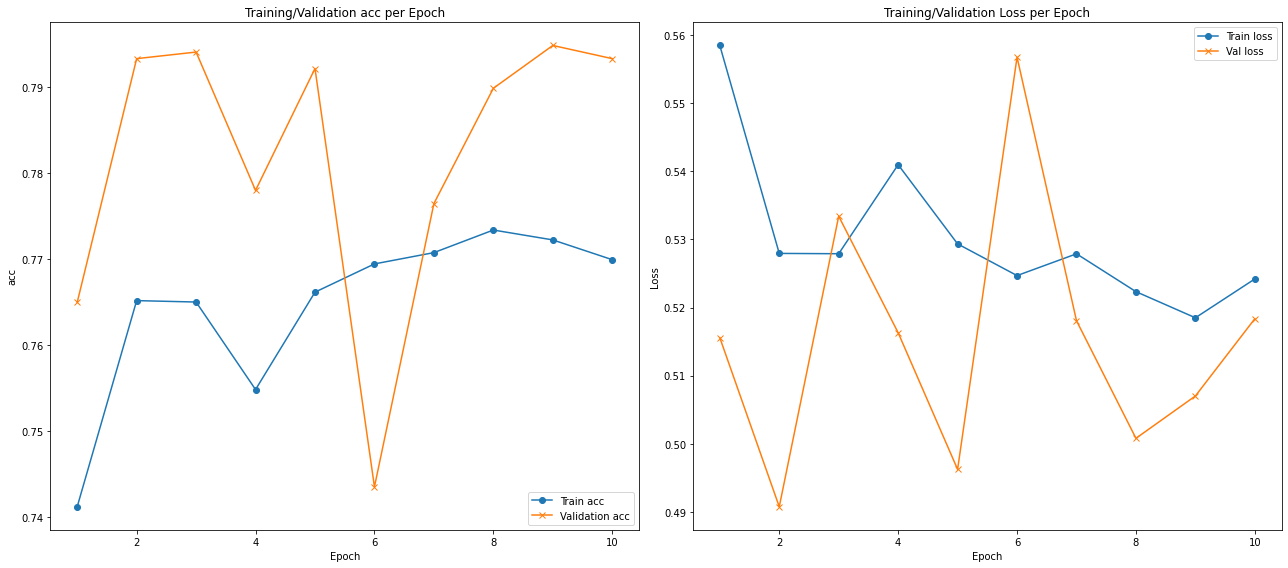

In [26]:
f, ax = plt.subplots(1, 2, figsize=[18, 8])
ax[0].plot([None] + hist.history['accuracy'], 'o-')
ax[0].plot([None] + hist.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax[0].legend(['Train acc', 'Validation acc'], loc = 0)
ax[0].set_title('Training/Validation acc per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('acc')

ax[1].plot([None] + hist.history['loss'], 'o-')
ax[1].plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax[1].legend(['Train loss', "Val loss"], loc = 0)
ax[1].set_title('Training/Validation Loss per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

<a id='confusion'></a>
## Confusion Matrix

<p style='font-size: 17px'>A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.</p>

In [27]:
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)

<p style='font-size: 17px'>Now, in order to plot confusion matrix, sklearn now provides a very efficient way. Rather than just going over lines of matplotlib code, we can just import <strong>ConfusionMatrixDisplay</strong> from the <strong>metrics</strong> module to directly plot it.</p>

<p class="alert alert-block alert-info" style='font-size: 17px'>
    📌 <strong>ConfusionMatrixDisplay</strong> takes two arguments:
    <ul class="alert alert-block alert-info">
        <li><strong>The actual result</strong></li>
        <li><strong>The prediction</strong></li></ul>
</p> 

<Figure size 720x576 with 0 Axes>

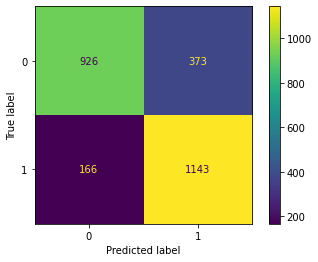

In [28]:
plt.figure(figsize=[10, 8])
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
plt.show()

<a id='final'></a>
# Performing final predictions

<p style='font-size: 17px'>Hence, we can perform the same on the test dataset to get it ready for the submission.</p>

In [29]:
preds = best_model.predict(test)
preds[:5]

array([[0.7835912 ],
       [0.04189292],
       [0.7835912 ],
       [0.7835912 ],
       [0.63319874]], dtype=float32)

In [30]:
survived = [1 if x > 0.5 else 0 for x in preds]
survived[:5]

[1, 0, 1, 1, 1]

In [31]:
for i in range(len(survived)):
    survived[i] = bool(survived[i])

survived[:5]

[True, False, True, True, True]

In [32]:
subs = pd.DataFrame({'PassengerId': ids, 'Transported': survived})
subs.to_csv('subs.csv', index=False)

<h3>If you are here and find this notebook useful, an upvote would really mean a lot to me & would keep me motivated.</h3>
<h3>Thank You!</h3>

<h4>Have a wonderful day! 😄</h4>